## To-do list
* Some cohort exploration based on deletion of subjects

* Look at variable correlations & clustering (if possible) -- suspect eg that systolic/diastolic will cluster based on prev work & means we can get away with using a variable score or one but not the other

~~* Create initial kitchen-sink model(s)
    * Identifier variables: ruid, visit_id, admit_date, discharge_date
    * Outcome variables: **readmit_30d**, readmit_time
    * Fixed effects (initially): ICD9, CPTs, medications, race, stay length, sex, DOB/age, pregnancy indicator, bmi
    * Random effects (initially): labs, number of transfers
    * Try as both: # transfers, stay length~~ **NOPE** -- not enough data to do mixed effects
    
    
* Do one model with all fixed effects first

* Model checking!!

## For a general modeling pipeline:
Need a utility function that:
1. Takes a DF and a list of variables,
2. Makes a GLM and samples from it,
3. Returns the trace & the model.

This will create a bunch of models & traces to check model diagnostics on, LOO, WAIC, etc & pick some "good" models.

Then need utility functions for:
1. Plotting chosen diagnostics.
2. Doing model comparisons using WAIC/LOO.
3. Measuring the accuracy vs validation set -- this will require refitting the model & using sample_ppc w/ shared theano variables to predict off the validation set.

FINALLY, take the best model that pops out of the above & refit it with both train+validation sets, then use it to predict the test set as final check of accuracy.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")

In [34]:
df = pd.read_csv('../data/merged.csv', parse_dates=['admit_date','discharge_date','dob','dod'])

In [17]:
df.head()

,ruid,visit_id,admit_date,discharge_date,stay_length,n_transfers,readmit_time,readmit_30d,sex,dob,...,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr,age,total_encounters,group
0,50135262,0,2007-02-08,2007-02-12,4,2,172 days 00:00:00.000000000,0,0,1949-09-20,...,32.0,334.0,140.0,58.0,44.710,0.0,123.677830,57.385352,10,train
1,50135262,1,2007-08-03,2007-08-06,3,3,22 days 00:00:00.000000000,1,0,1949-09-20,...,39.0,291.5,121.0,61.0,45.025,0.0,89.505000,57.867214,10,train
2,50135262,2,2007-08-28,2007-08-29,1,1,179 days 00:00:00.000000000,0,0,1949-09-20,...,38.0,308.0,131.0,60.0,46.230,0.0,107.450000,57.935661,10,train
3,50135262,3,2008-02-24,2008-02-28,4,2,44 days 00:00:00.000000000,0,0,1949-09-20,...,38.0,274.0,151.0,74.0,47.140,0.0,73.010770,58.428474,10,train
4,50135262,4,2008-04-12,2008-04-13,1,1,928 days 00:00:00.000000000,0,0,1949-09-20,...,36.0,330.0,134.0,66.0,47.360,0.0,84.358415,58.559890,10,train


In [16]:
df.group.value_counts()

train    12912
test      4229
valid     3992
Name: group, dtype: int64

In [35]:
df.sex = (df.sex == 'M')*1
df.drop('race',axis=1, inplace = True) # can't use this; there's just too few of some races for it to be meaningful

In [45]:
id_vars = list(df.columns[0:3]) + ['total_encounters','group']
meds = list(df.columns[df.columns.str.contains('med_')])
cpts = list(df.columns[df.columns.str.contains('cpt_')])
dx = list(df.columns[df.columns.str.contains('icd_dx')])
labs = list(df.loc[:,'bun':'egfr'].columns)
demos = ['age','sex','dob','dod']
outcomes = ['readmit_time','readmit_30d']
visit = cpts + ['n_transfers','stay_length','icd_proc','icd_visit']
non_outcomes = demos + meds + dx + labs + visit

In [43]:
meds_desc = df[meds].describe()
visit_desc = df[visit].describe()
dx_desc = df[dx].describe()
labs_desc = df[labs].describe()
demos_desc = df[demos].describe()

In [47]:
meds_desc.iloc[:,0:10] # need to think of a clever way to look at all these slices, eventually

,med_Antihypertensive Agents,"med_Analgesics, Opioid",med_Narcotics,med_Antipyretics,med_Anti-Bacterial Agents,"med_Anti-Inflammatory Agents, Non-Steroidal","med_Analgesics, Non-Narcotic",med_Antiemetics,med_Diuretics,med_Anti-Arrhythmia Agents
count,21133.000000,21133.000000,21133.000000,21133.000000,21133.000000,21133.000000,21133.000000,21133.000000,21133.000000,21133.000000
mean,8.683954,12.383476,11.554441,8.364832,10.748592,6.186486,6.829603,8.419202,5.258837,5.361473
std,21.972842,19.863092,19.227850,11.993470,23.992821,8.886326,9.790773,18.180743,12.476156,12.303319
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,3.000000,7.000000,6.000000,5.000000,3.000000,4.000000,4.000000,3.000000,0.000000,1.000000
75%,11.000000,16.000000,14.000000,11.000000,11.000000,8.000000,9.000000,9.000000,6.000000,6.000000
max,1844.000000,1122.000000,1112.000000,318.000000,816.000000,250.000000,245.000000,577.000000,439.000000,455.000000


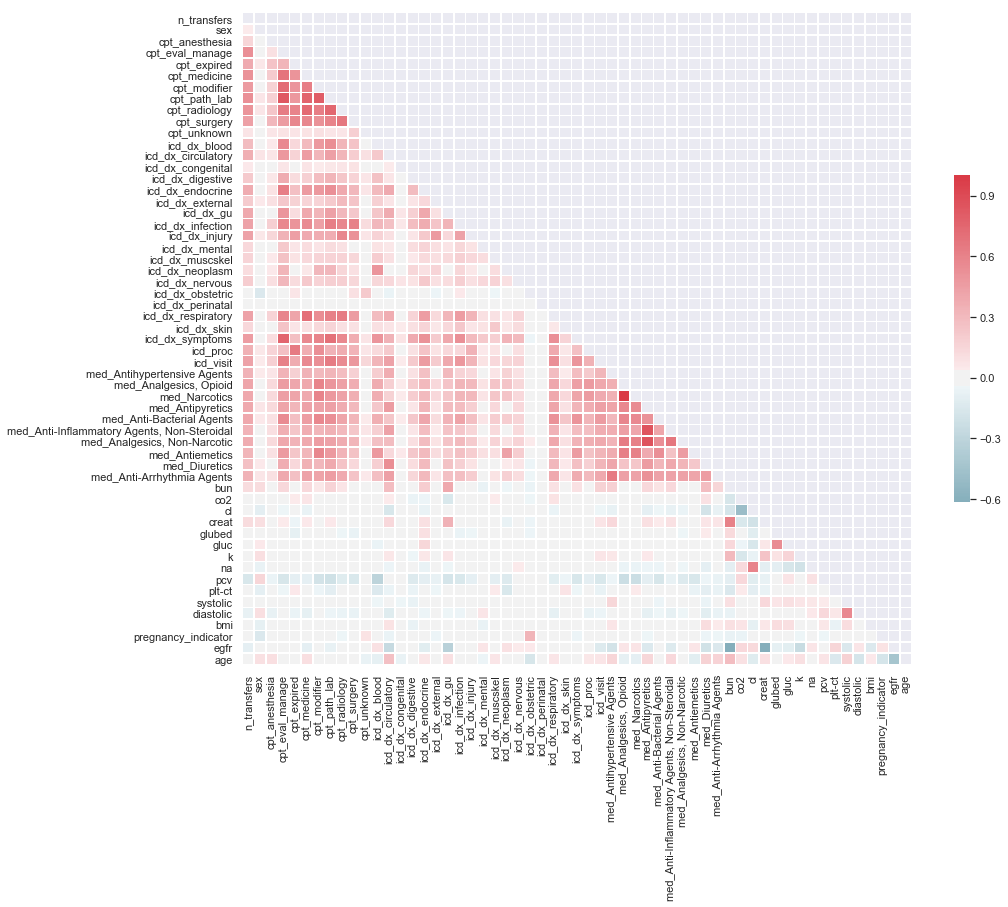

In [181]:
corr = df[]

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, center = 0);

In [ ]:
def test_bayesian_glm():
    pass

def model_gen(outcome = 'readmit_30d', variables = non_outcomes, data = df_train, **kwargs):
    
    
    
    return model, trace